# Brain Tumour Classification
***
## Table of Contents
***

In [1]:
import torch
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from torchvision import datasets, transforms, models
from torchinfo import summary
from torchmetrics import Accuracy, F1Score
from pathlib import Path
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Subset

## 1. Introduction

## 2. Device Agnostic Code
Mac GPU acceleration (`mps` backend) delivers significant speed-up over CPU for deep learning tasks, especially for large models and batch sizes. On Windows, `cuda` is used instead of `mps`.

In [2]:
# DEVICE = torch.device(device="cuda" if torch.cuda.is_available() else "cpu") # For Windows
DEVICE = torch.device(
    device="mps" if torch.backends.mps.is_available() else "cpu"
)  # For MacOS
DEVICE

device(type='mps')

## 3. Loading Data
Retrieved from [Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

In [3]:
data_path = Path("_datasets/brain_mri")

if data_path.is_dir():
    print(f"{data_path} directory exists.")
else:
    print(f"{data_path} directory NOT FOUND!")

_datasets/brain_mri directory exists.


In [4]:
def walk_through_dir(dir_path) -> None:
    for (
        directory_path,
        directory_names,
        file_names,
    ) in os.walk(dir_path):
        print(
            f"{len(directory_names)} directories and {len(file_names)} images found in {directory_path}"
        )

In [5]:
walk_through_dir(data_path)

2 directories and 0 images found in _datasets/brain_mri
4 directories and 0 images found in _datasets/brain_mri/Training
0 directories and 1457 images found in _datasets/brain_mri/Training/pituitary
0 directories and 1595 images found in _datasets/brain_mri/Training/notumor
0 directories and 1321 images found in _datasets/brain_mri/Training/glioma
0 directories and 1339 images found in _datasets/brain_mri/Training/meningioma
4 directories and 0 images found in _datasets/brain_mri/Testing
0 directories and 300 images found in _datasets/brain_mri/Testing/pituitary
0 directories and 405 images found in _datasets/brain_mri/Testing/notumor
0 directories and 300 images found in _datasets/brain_mri/Testing/glioma
0 directories and 306 images found in _datasets/brain_mri/Testing/meningioma


## 4. Preparing Data
### Data Transformation
For transfer learning using pretrained models in PyTorch, it is a common and effective practice to normalise the dataset using the standard mean and standard deviation values of the ImageNet dataset, on which many pretrained models were originally trained. This ensures that the input data distribution matches the distribution expected by the pretrained model, leading to better convergence and improved performance during fine-tuning.

[Reference - PyTorch Forums](https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670)

In addition to normalisation, various data augmentation techniques (such as random flips and random rotations) are applied to increase data diversity and improve the model's generalisation capability.

In [6]:
IMAGE_SIZE = 224
IMAGE_NET_MEANS = [0.485, 0.456, 0.406]
IMAGE_NET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomRotation(degrees=10),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=IMAGE_NET_MEANS,
            std=IMAGE_NET_STDS,
        ),
    ]
)

test_transform = transforms.Compose(
    transforms=[
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=IMAGE_NET_MEANS,
            std=IMAGE_NET_STDS,
        ),
    ]
)

## Preparing DataLoaders
The downloaded dataset contains only training and testing subsets; therefore, I split the original test subset into separate validation and test datasets in a 50:50 ratio.

In [7]:
from sklearn.model_selection import train_test_split

TRAIN_DIR = "_datasets/brain_mri/Training"
TEST_DIR = "_datasets/brain_mri/Testing"
BATCH_SIZE = 16

train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
subset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

# Get all indices
indices = list(range(len(subset)))

# Stratified split based on targets
train_idx, test_idx = train_test_split(
    indices, test_size=0.5, stratify=subset.targets, random_state=42
)

# Create proper Subset datasets
val_dataset = Subset(dataset=subset, indices=train_idx)
test_dataset = Subset(dataset=subset, indices=test_idx)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [8]:
print(f"Batch size: {BATCH_SIZE}")
print(f"- train_dataset: {len(train_dataset)} -> train_loader: {len(train_loader)}")
print(f"- val_dataset: {len(val_dataset)} -> val_loader: {len(val_loader)}")
print(f"- test_dataset: {len(test_dataset)} -> test_loader: {len(test_loader)}")


Batch size: 16
- train_dataset: 5712 -> train_loader: 357
- val_dataset: 655 -> val_loader: 41
- test_dataset: 656 -> test_loader: 41


In [9]:
print(f"Classes: {train_dataset.classes}")
print(f"Classes with indices: {train_dataset.class_to_idx}")

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']
Classes with indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 5. Understanding Data

In [10]:
def show_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(9, 9))
    cols, rows = 3, 3
    indices = random.sample(population=range(len(dataset)), k=num_images)
    for i, index in enumerate(indices):
        image, label = dataset[index]
        image = image.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
        mean = np.array(IMAGE_NET_MEANS)
        std = np.array(IMAGE_NET_STDS)
        image = std * image + mean
        image = np.clip(image, 0, 1)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.tight_layout()
        plt.axis("off")
    plt.show()

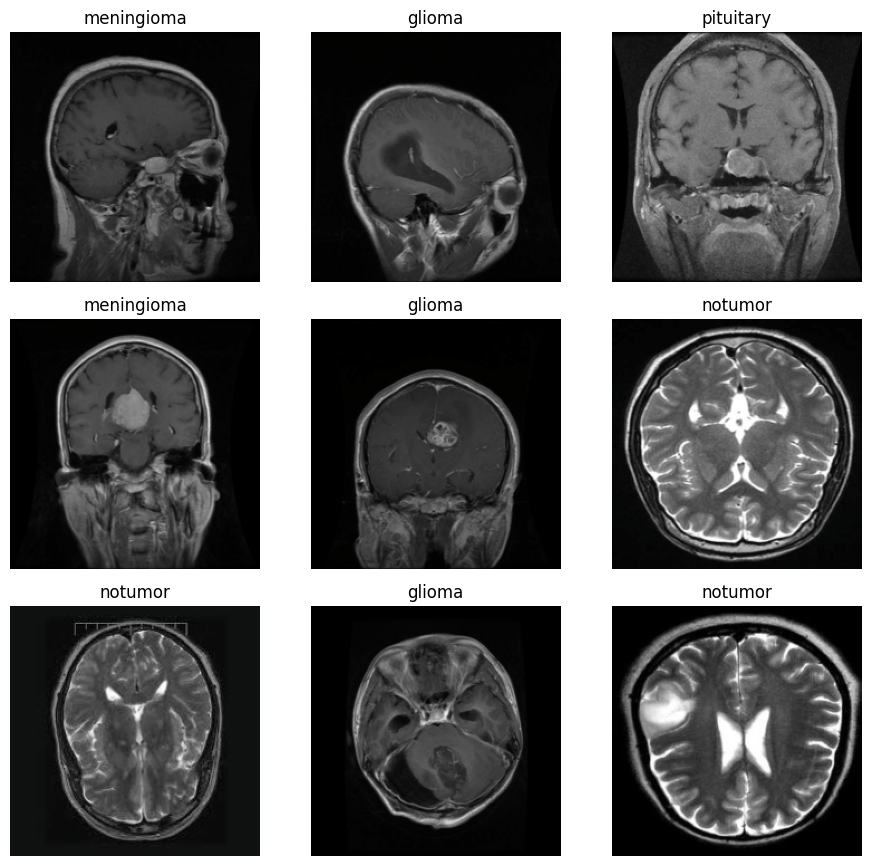

In [11]:
CLASS_NAMES = train_dataset.classes
show_images(dataset=test_dataset, class_names=CLASS_NAMES)
N_CLASSES = len(CLASS_NAMES)

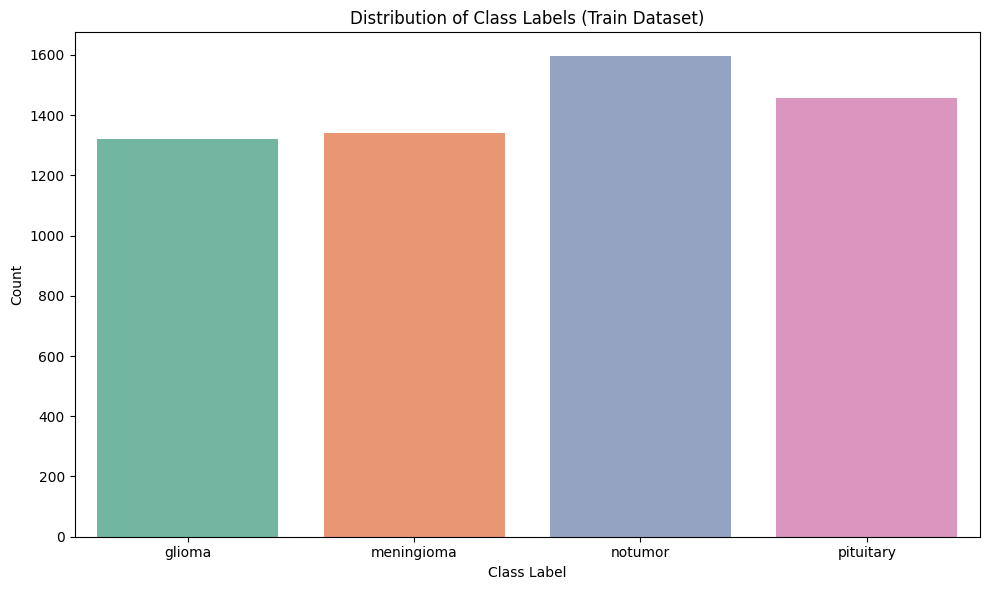

In [12]:
train_classes = [CLASS_NAMES[label_idx] for _, label_idx in train_dataset]
unique_vals, counts = np.unique(train_classes, return_counts=True)
df_dist = pd.DataFrame({"Class Label": unique_vals, "Count": counts})

plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x="Class Label", y="Count", hue="Class Label", palette="Set2")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Distribution of Class Labels (Train Dataset)")
plt.tight_layout()
plt.show()

## 6. Transfer Learning
Transfer learning is a powerful technique in deep learning where a model pretrained on a large, general dataset is adapted for a related task. This practice improves performance while reducing the amount of training data and training time required.

Setting `param.requires_grad = False` in PyTorch freezes the model parameters (weights and biases), preventing gradient computations and updates during training. This allows parts of the model to remain unchanged while selectively training other layers.

### ResNet-18
ResNet-18 is a convolutional neural network known for its residual connections, which help training deeper networks by mitigating the vanishing gradient problem. It consists of 18 layers structured into four sequential blocks (layer1 to layer4), each containing two residual blocks. In our setup, we freeze all parameters except for the final block (layer4), which is unfrozen to allow the model to adapt deeper, more complex features specific to the image data while keeping most of the pretrained features intact.

In [13]:
class ResNet18(nn.Module):
    def __init__(self, num_classes=4, freeze=True, device="cpu"):
        super().__init__()
        self.device = device
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(
            in_features=self.model.fc.in_features, out_features=num_classes
        )

        if freeze:
            # Freeze all layers initially
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze only the 4th layer by default
            for param in self.model.layer4.parameters():
                param.requires_grad = True

        self.to(device=self.device)

    def forward(self, x):
        return self.model(x)

### EfficientNet B0
EfficientNet B0 is a convolutional neural network architecture optimised for both accuracy and efficiency using a compound scaling method that uniformly scales network depth, width, and resolution. Its feature extractor consists of multiple blocks arranged sequentially. In our setup, we freeze all layers except for the deepest two feature blocks (indices 6 and 7) and the final classifier head. This approach allows fine-tuning of the most specialised, high-level features as well as the classification layer, enabling the model to better capture domain-specific patterns while retaining pretrained knowledge.

In [14]:
class EfficientNetB0(nn.Module):
    def __init__(self, num_classes=4, freeze=True, device="cpu"):
        super().__init__()
        self.device = device
        self.model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.DEFAULT
        )
        n_features = self.model.classifier[1].in_features

        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(n_features, num_classes),
            nn.ReLU(),
        )
        self.to(device=device)

        if freeze:
            # Freeze all layers initially
            for param in self.model.parameters():
                param.requires_grad = False
            # Unfreeze only the 2 last layers and classifier by default
            for param in self.model.features[7].parameters():
                param.requires_grad = True
            for param in self.model.features[6].parameters():
                param.requires_grad = True
            for param in self.model.classifier.parameters():
                param.requires_grad = True

    def forward(self, x):
        return self.model(x)

In [15]:
resnet18 = ResNet18(num_classes=N_CLASSES, device=DEVICE)
enb0 = EfficientNetB0(num_classes=N_CLASSES, device=DEVICE)

In [16]:
for model in [resnet18, enb0]:
    print(
        summary(
            model=model,
            input_size=(
                BATCH_SIZE,
                3,
                IMAGE_SIZE,
                IMAGE_SIZE,
            ),  # (batch_size, colour channels, height, width)
            verbose=0,
            col_names=["input_size", "output_size", "num_params", "trainable"],
            col_width=20,
            row_settings=["var_names"],
        )
    )
    print("\n")

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ResNet18 (ResNet18)                           [16, 3, 224, 224]    [16, 4]              --                   Partial
├─ResNet (model)                              [16, 3, 224, 224]    [16, 4]              --                   Partial
│    └─Conv2d (conv1)                         [16, 3, 224, 224]    [16, 64, 112, 112]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [16, 64, 112, 112]   [16, 64, 112, 112]   (128)                False
│    └─ReLU (relu)                            [16, 64, 112, 112]   [16, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [16, 64, 112, 112]   [16, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [16, 64, 56, 56]     [16, 64, 56, 56]     --                   False
│    │    └─BasicBlock (0)                    [16, 64, 56, 56]     [16, 64, 56

## 7. Evaluation Metrics
We will use the following evaluation metrics:
- `torchmetrics.Accuracy`
- `torchmetrics.F1Score`

In [17]:
accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES).to(device=DEVICE)
f1 = F1Score(task="multiclass", num_classes=N_CLASSES, average="macro").to(
    device=DEVICE
)
metrics = [accuracy, f1]

## 8. Loss Function
### Cross-Entropy Loss
Cross-Entropy Loss is a loss function used for classification problems, particularly when the model outputs probabilities using a softmax activation in the final layer. It measures the difference between the true labels and the predicted probability distribution.

For a single data point, the cross-entropy loss is defined as:

\begin{align*}
    L = - \sum^{k}_{i=1}y_{i}\log{(\hat y_{i})}
\end{align*}

where:
- $y_i$: True label for the $i$-th class. If one-hot encoded, $y_{i} = 1$ for the corrected class, $y_{i} = 0$ otherwise.
- $\hat y_i$: Predicted probability for the $i$-th class.
- $k$: Number of classes.

For a batch of $m$ data point:

\begin{align*}
    C = \dfrac{1}{m} \sum^{m}_{j=1} \left (- \sum^{k}_{i=1}y_{j, i}\log{(\hat y_{j, i})} \right)
\end{align*}

where:
- $C$: Average cross-entropy loss over the batch.
- $m$: Number of training examples (batch size).
- $k$: Number of classes.
- $y_{j, i} \in { 0, 1}$: Indicator that true class for sample $j$ corresponds to class $i$.
- $\hat y_{j, i} \in { 0, 1}$: Predicted probability for sample $j$ belonging to class $i$.

In PyTorch:
- Use `nn.CrossEntropyLoss()` directly with raw logits.
- Do not apply `Softmax()` or `LogSoftmax()` manually before the loss.
- Internally, `nn.CrossEntropyLoss() = LogSoftmax() + NegativeLogLikelihoodLoss()`. 

In [18]:
criterion = nn.CrossEntropyLoss()

## 9. Optimiser
An optimiser in neural networks is used to adjust the parameters (weights and biases) of a model during training to minimise the loss. Optimisers are essential for enabling neural networks to learn from data: without them, the model would not improve over time.

**AdamW** (a variant of the Adam optimiser) separates weight decay (L2 regularisation) from the gradient updates. This decoupling often improves a model's generalisation performance compared to the original Adam optimiser, reducing the risk of overfitting, especially in large-scale models.

**ReduceLROnPlateau** is a learning rate scheduler that monitors a specified metric (usually validation loss) and reduces the learning rate by a given factor if the metric stops improving for a certain number of epochs (`patience`). This allows the optimiser to take smaller, more precise steps when progress plateaus, often leading to better final model performance.

In [19]:
LEARNING_RATE = 0.001
DECAY_RATE = 1e-4
resnet18_optimiser = AdamW(
    params=filter(lambda p: p.requires_grad, resnet18.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
resnet18_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=resnet18_optimiser, mode="min", patience=3, factor=0.5
)

enb0_optimiser = AdamW(
    params=filter(lambda p: p.requires_grad, enb0.parameters()),
    lr=LEARNING_RATE,
    weight_decay=DECAY_RATE,
)
enb0_scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=enb0_optimiser, mode="min", patience=3, factor=0.5
)

## 10. Training and Evaluation
1. Iterate through epochs
1. For each epoch, iterate through training batches, perform training steps, calculate the train loss and evaluation metrics per batch.
1. For each epoch, iterate through validation batches, perform validation steps, calculate the validation loss and evaluation metrics per batch.


### Training Steps
1. Zero the gradients
    - Clear the gradients from the previous iteration to prevent accumulation across batches.
1. Forward pass
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1 Score) for the current batch.
1. Backward pass
    - Compute gradients of the loss with respect to the model's parameters via backpropagation.
    - Update the parameter $\theta$ using the computed gradients, typically following:
    
    $$
        \theta \leftarrow \theta - \eta \dfrac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\eta$ is the learning rate.
1. Average training loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.


In [20]:
def train_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimiser: AdamW,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    model.train()
    for metric in metrics:
        metric.reset()
    n_total_samples = len(data_loader.dataset)
    train_loss = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_size = inputs.size(0)

        # Optimiser zero grad without intervening forward pass
        optimiser.zero_grad()

        # Forward pass
        y_logits = model(inputs)

        # Calculate loss
        loss = criterion(y_logits, labels)
        train_loss += loss.item() * batch_size

        # Calculate metrics
        y_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_probs, dim=1)

        for metric in metrics:
            metric.update(y_preds, labels)

        # Loss backward for backpropagation (computing gradients)
        loss.backward()

        # Optimiser step to apply gradients and update parameters
        optimiser.step()

    avg_train_loss = train_loss / n_total_samples  # Average (number of samples)
    train_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_train_loss, train_metric_scores

### Validation Steps
1. Forward pass
    - Set the model to evaluation mode (which disables dropout and batch normalisation and desactivates gradient tracking for safety).
    - Pass inputs through the model to obtain predictions.
1. Calculate loss and evaluation metrics per batch
    - Measure how far the predictions deviate from the true labels using a loss function.
    - Compute evaluation metrics (e.g., accuracy, F1-Score) for the current batch.
1. Average test loss and evaluation metrics
    - Calculate the mean loss and metric values across all batches in the epoch.

In [21]:
def validation_step(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[float, list[float]]:
    model.eval()
    validation_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            y_logits = model(inputs)

            # 2. Calculate loss
            loss = criterion(y_logits, labels)
            validation_loss += loss.item() * batch_size

            # 3. Calculate metrics
            y_probs = torch.softmax(input=y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)

            for metric in metrics:
                metric.update(y_preds, labels)

    avg_val_loss = validation_loss / n_total_samples
    val_metric_scores = [metric.compute().item() * 100 for metric in metrics]
    return avg_val_loss, val_metric_scores

In [ ]:
def train_and_validate(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    criterion: nn.Module,
    optimiser: AdamW,
    scheduler: lr_scheduler,
    metrics: list[nn.Module],
    device: torch.device,
    total_epochs: int,
) -> dict[str, list[float]]:
    model.to(device)
    epochs_range = range(1, total_epochs + 1)
    best_loss = float("inf")
    # patience_counter = 0
    best_epoch = 0
    model_name = model.__class__.__name__.lower()

    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
    }

    start_time = time.time()

    for epoch in epochs_range:
        train_loss, train_metrics = train_step(
            model=model,
            data_loader=train_loader,
            criterion=criterion,
            optimiser=optimiser,
            metrics=metrics,
            device=device,
        )
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_metrics[0])
        history["train_f1"].append(train_metrics[1])

        val_loss, val_metrics = validation_step(
            model=model,
            data_loader=val_loader,
            criterion=criterion,
            metrics=metrics,
            device=device,
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_metrics[0])
        history["val_f1"].append(val_metrics[1])

        scheduler.step(val_loss)  # Update learning rate based on validation loss

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(obj=model.state_dict(), f=f"{model_name}_best.pth")
            # patience_counter = 0
            best_epoch = epoch
        # else: # Early Stopping
        #     patience_counter += 1
        #     if patience_counter >= 5:
        #         print(f"Early stopping at epoch {epoch}")
        #         break

        print(f"Epoch [{epoch}/{total_epochs}]\n==========")
        print(
            f"{'Train Loss:':<12}{train_loss:>6.4f} | {'Train Accuracy:':<15}{train_metrics[0]:>6.2f}% | {'Train F1:':<10}{train_metrics[1]:>6.2f}%"
        )
        print(
            f"{'Val Loss:':<12}{val_loss:>6.4f} | {'Val Accuracy:':<15}{val_metrics[0]:>6.2f}% | {'Val F1:':<10}{val_metrics[1]:>6.2f}%\n"
        )

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training and validation completed in {elapsed_time:.2f} seconds.\n")
    print(f"The best-performing was saved at epoch: {best_epoch}")
    return history

In [23]:
EPOCHS = 20
EPOCH_RANGE = range(1, EPOCHS + 1)
MODEL_NAME_RESNET18 = "ResNet18"
MODEL_NAME_ENB0 = "EfficientNet B0"

print("Training ResNet18...")
resnet18_history = train_and_validate(
    model=resnet18,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=resnet18_optimiser,
    scheduler=resnet18_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

print("Training EfficientNet B0...")
enb0_history = train_and_validate(
    model=enb0,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimiser=enb0_optimiser,
    scheduler=enb0_scheduler,
    metrics=metrics,
    device=DEVICE,
    total_epochs=EPOCHS,
)

Training ResNet18...
Epoch [1/20]
Train Loss: 0.3771 | Train Accuracy: 86.83% | Train F1:  86.47%
Val Loss:   0.2813 | Val Accuracy:   90.99% | Val F1:    90.98%

Epoch [2/20]
Train Loss: 0.2215 | Train Accuracy: 92.07% | Train F1:  91.81%
Val Loss:   0.1778 | Val Accuracy:   94.05% | Val F1:    93.75%

Epoch [3/20]
Train Loss: 0.1701 | Train Accuracy: 94.10% | Train F1:  93.90%
Val Loss:   0.1626 | Val Accuracy:   94.20% | Val F1:    93.90%

Epoch [4/20]
Train Loss: 0.1485 | Train Accuracy: 94.87% | Train F1:  94.67%
Val Loss:   0.1694 | Val Accuracy:   93.59% | Val F1:    93.48%

Epoch [5/20]
Train Loss: 0.1139 | Train Accuracy: 95.71% | Train F1:  95.55%
Val Loss:   0.1601 | Val Accuracy:   93.59% | Val F1:    93.23%

Epoch [6/20]
Train Loss: 0.1011 | Train Accuracy: 96.52% | Train F1:  96.39%
Val Loss:   0.1070 | Val Accuracy:   95.42% | Val F1:    95.14%

Epoch [7/20]
Train Loss: 0.0963 | Train Accuracy: 96.39% | Train F1:  96.25%
Val Loss:   0.0835 | Val Accuracy:   97.10% | Val 

## 11. Results
### Overall Performance

In [24]:
resnet18_train_metrics = {
    "Loss": resnet18_history["train_loss"],
    "Accuracy": resnet18_history["train_acc"],
    "F1 Score": resnet18_history["train_f1"],
}

resnet18_val_metrics = {
    "Loss": resnet18_history["val_loss"],
    "Accuracy": resnet18_history["val_acc"],
    "F1 Score": resnet18_history["val_f1"],
}

enb0_train_metrics = {
    "Loss": resnet18_history["train_loss"],
    "Accuracy": resnet18_history["train_acc"],
    "F1 Score": resnet18_history["train_f1"],
}

enb0_val_metrics = {
    "Loss": enb0_history["val_loss"],
    "Accuracy": enb0_history["val_acc"],
    "F1 Score": enb0_history["val_f1"],
}

In [25]:
def plot_results(epochs_range, model_name, train_metrics, val_metrics) -> None:
    metric_names = list(train_metrics.keys())
    n_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=n_metrics, figsize=(16, 6))
    axes = axes.flatten()
    for i, metric_name in enumerate(metric_names):
        ax = axes[i]
        ax.plot(
            epochs_range,
            train_metrics[metric_name],
            label=f"Train {metric_name}",
        )  # Train metric
        ax.plot(
            epochs_range,
            val_metrics[metric_name],
            label=f"Validation {metric_name}",
        )  # Validation metric
        ax.set_title(f"{model_name}: {metric_name} Over Epochs", fontsize=12)
        ax.legend()
        ax.set_xlabel("Epoch")
        if metric_name == "Loss":
            ax.set_ylabel("Loss")
        else:
            ax.set_ylabel(f"f{metric_name} (%)")

    plt.tight_layout()
    plt.show()


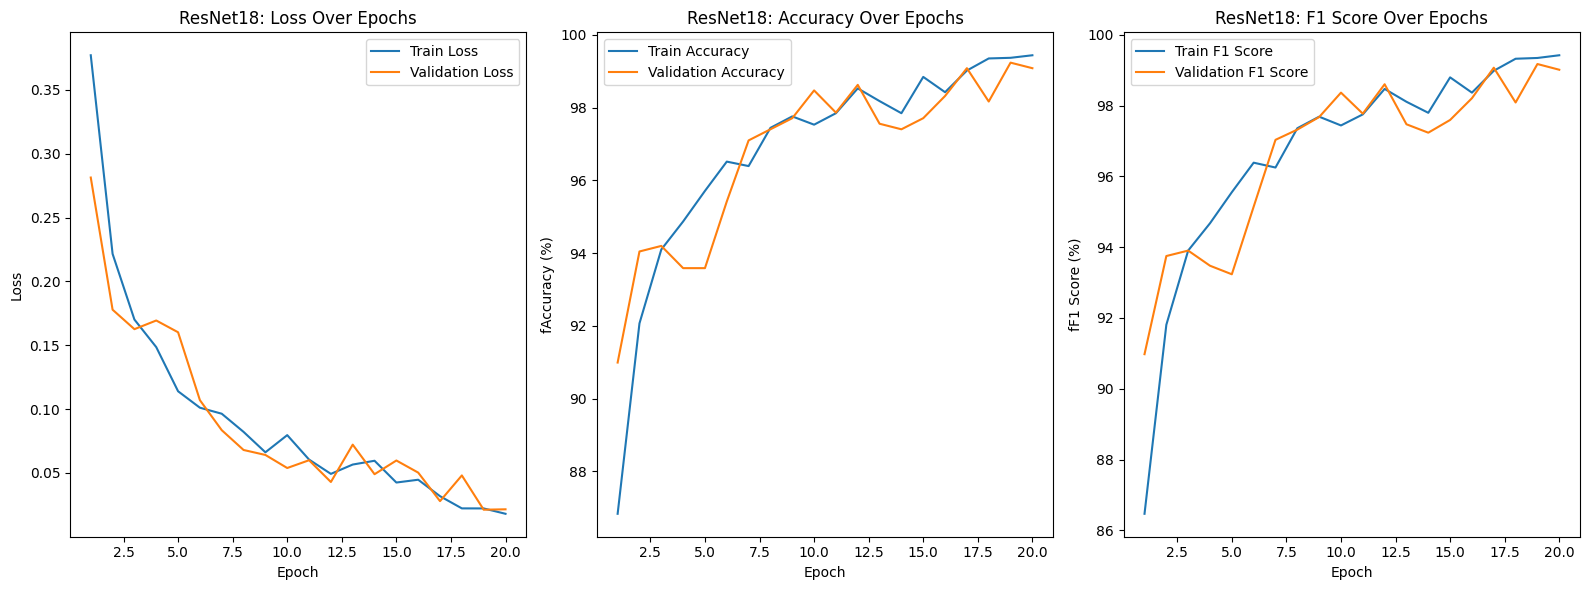

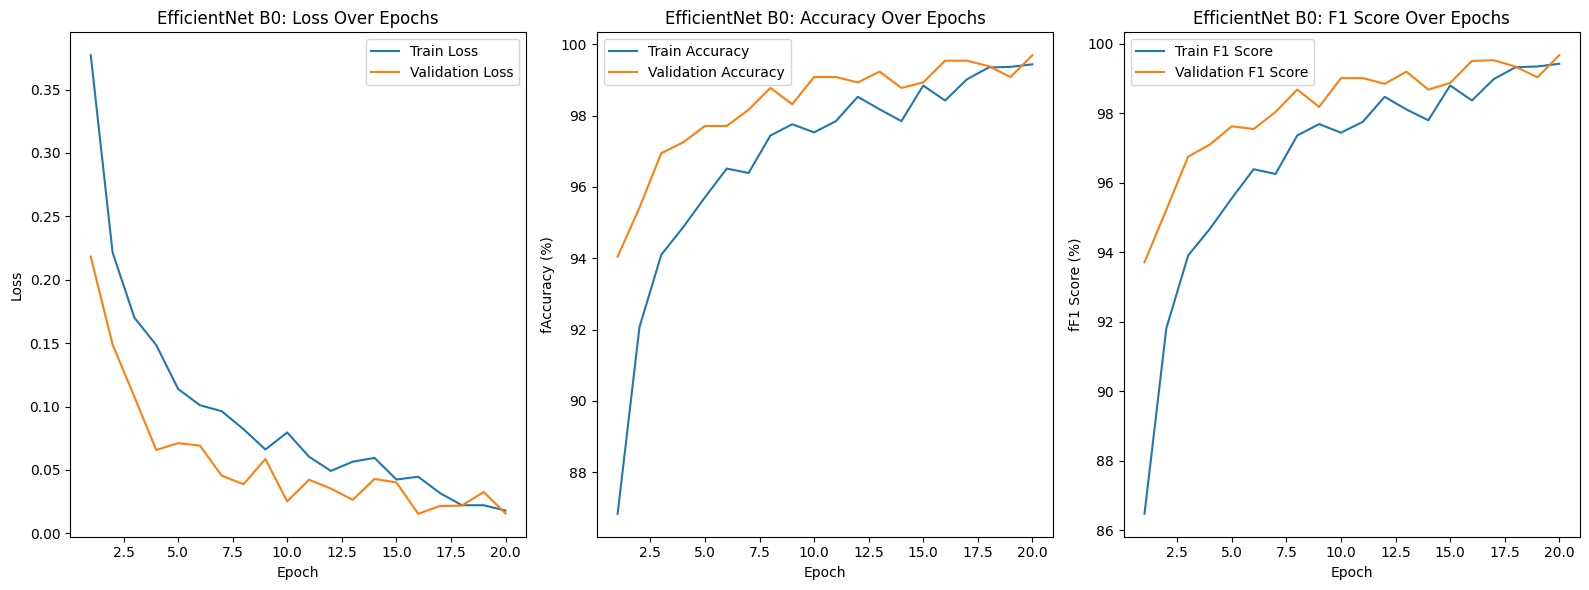

In [26]:
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_RESNET18,
    train_metrics=resnet18_train_metrics,
    val_metrics=resnet18_val_metrics,
)
plot_results(
    epochs_range=EPOCH_RANGE,
    model_name=MODEL_NAME_ENB0,
    train_metrics=enb0_train_metrics,
    val_metrics=enb0_val_metrics,
)

### Classifications

In [27]:
def make_all_predictions(
    model: nn.Module,
    model_name: str,
    data_loader: DataLoader,
    criterion: nn.Module,
    metrics: list[nn.Module],
    device: torch.device,
) -> tuple[torch.Tensor, torch.Tensor]:
    model_file_name = model.__class__.__name__.lower()
    model.load_state_dict(
        state_dict=torch.load(f=f"{model_file_name}_best.pth", map_location=device),
    )
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []
    test_loss = 0.0
    n_total_samples = len(data_loader.dataset)
    for metric in metrics:
        metric.reset()

    with torch.inference_mode():
        for inputs, labels in data_loader:
            batch_size = inputs.size(0)
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward pass
            y_logits = model(inputs)
            y_probs = torch.softmax(y_logits, dim=1)
            y_preds = torch.argmax(y_probs, dim=1)

            all_preds.append(y_preds.cpu())
            all_labels.append(labels.cpu())

            # 2. Calculate test loss
            test_loss += criterion(y_logits, labels).item() * batch_size

            # 3. Calculate test metrics
            for metric in metrics:
                metric.update(y_preds, labels)

    test_loss /= n_total_samples
    test_acc = metrics[0].compute().item() * 100
    test_f1 = metrics[1].compute().item() * 100

    print(f"{model_name}\n==========")
    print(
        f"{'Test Loss:':<12}{test_loss:>6.4f} | {'Test Accuracy:':<15}{test_acc:>6.2f}% | {'Test F1:':<10}{test_f1:>6.2f}%\n"
    )
    all_preds_tensor = torch.cat(all_preds)
    all_labels_tensor = torch.cat(all_labels)
    return all_preds_tensor, all_labels_tensor

In [28]:
resnet18 = ResNet18(num_classes=N_CLASSES, freeze=False, device=DEVICE)

all_preds_resnet18, all_labels_resnet18 = make_all_predictions(
    model=resnet18,
    model_name=MODEL_NAME_RESNET18,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)

enb0 = EfficientNetB0(num_classes=N_CLASSES, freeze=False, device=DEVICE)

all_preds_enb0, all_labels_enb0 = make_all_predictions(
    model=enb0,
    model_name=MODEL_NAME_ENB0,
    data_loader=test_loader,
    criterion=criterion,
    metrics=metrics,
    device=DEVICE,
)

ResNet18
Test Loss:  0.0260 | Test Accuracy:  98.93% | Test F1:   98.84%

EfficientNet B0
Test Loss:  0.0160 | Test Accuracy:  99.24% | Test F1:   99.18%



### Missclassifiations

In [29]:
def print_missclassifications(all_preds, all_labels, model_name) -> None:
    missclassified = all_preds != all_labels
    n_missclassified = int(missclassified.sum())
    missclassified_rate = 100 * n_missclassified / len(all_labels)
    print(f"{model_name}\n==========")
    print(
        f"Number of failed predictions: {n_missclassified}/{len(all_labels)} ({missclassified_rate:.2f}%)\n"
    )

In [30]:
print_missclassifications(
    all_preds=all_preds_resnet18,
    all_labels=all_labels_resnet18,
    model_name=MODEL_NAME_RESNET18,
)

print_missclassifications(
    all_preds=all_preds_enb0,
    all_labels=all_labels_enb0,
    model_name=MODEL_NAME_ENB0,
)

ResNet18
Number of failed predictions: 7/656 (1.07%)

EfficientNet B0
Number of failed predictions: 5/656 (0.76%)



### Confusion Matrix

In [31]:
def plot_confusion_matrix(cm, class_names, model_name) -> None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        data=cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name}: Confusion Matrix")
    plt.show()

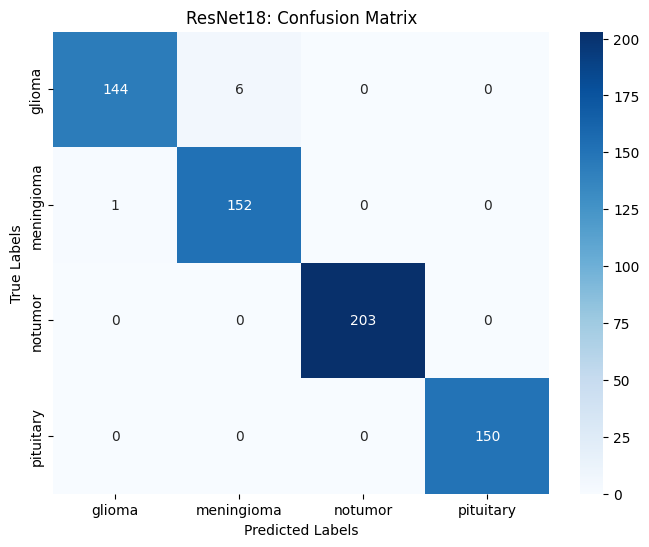

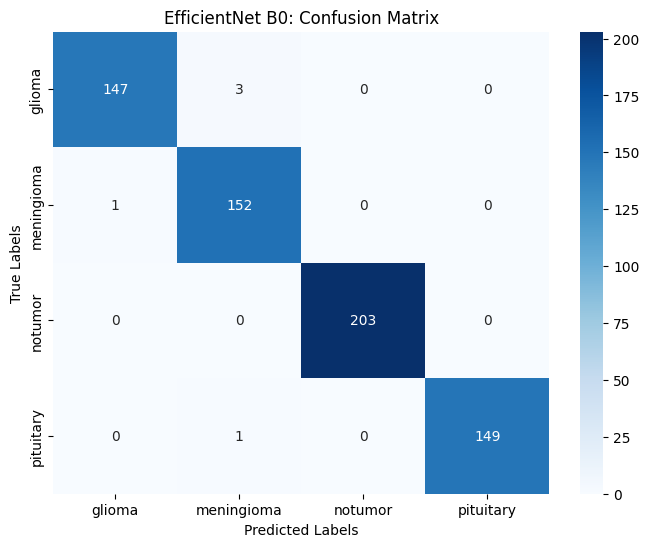

In [ ]:
cm_resnet18 = confusion_matrix(
    y_true=all_labels_resnet18,
    y_pred=all_preds_resnet18,
)

cm_enb0 = confusion_matrix(
    y_true=all_labels_enb0,
    y_pred=all_preds_enb0,
)

plot_confusion_matrix(
    cm=cm_resnet18,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_RESNET18,
)

plot_confusion_matrix(
    cm=cm_enb0,
    class_names=CLASS_NAMES,
    model_name=MODEL_NAME_ENB0,
)

## 12. Vision Transformers (ViT)